**IMPORTING LIBRARIES**

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import os as os
import logging
import json
import random
from PIL import Image

**IMPORTING DATASET**

In [2]:
dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
test_set, training_set, validation_set = dataset['test'], dataset['train'], dataset['validation']

**VISUALIZING THE DATASET**

In [3]:
num_training_examples  = dataset_info.splits['train'].num_examples
num_test_examples  = dataset_info.splits['test'].num_examples
num_validation_examples  = dataset_info.splits['validation'].num_examples

print('Number of training examples: {}'.format(num_training_examples))
print('Number of test examples: {}'.format(num_test_examples))
print('Number of validation examples: {}'.format(num_validation_examples))

num_classes = dataset_info.features['label'].num_classes
print('Number of classes: {}'.format(num_classes))

Number of training examples: 1020
Number of test examples: 6149
Number of validation examples: 1020
Number of classes: 102


In [4]:
for image, label in training_set.take(3):
  print('Image label: {}, Image shape: {}'.format(label, image.shape))

Image label: 72, Image shape: (500, 667, 3)
Image label: 84, Image shape: (500, 666, 3)
Image label: 70, Image shape: (670, 500, 3)


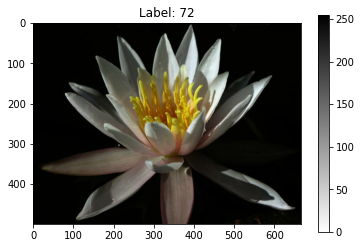

In [5]:
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('Label: {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.show()

**IMPORTING THE CLASS NAMES**

In [6]:
with open('/content/drive/MyDrive/class.json', 'r') as f:
    class_name = json.load(f)

print('Classes number:', len(class_name), '\n')
print(class_name)

Classes number: 102 

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved po

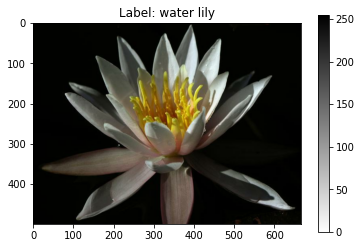

In [7]:
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('Label: {}'.format(class_name[str(label+1)]))
plt.colorbar()
plt.grid(False)
plt.show()

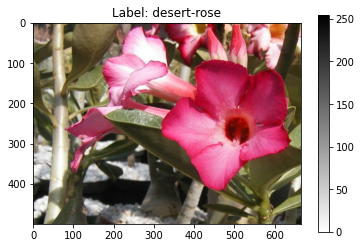

In [8]:
for image, label in training_set.take(2):
    image = image.numpy().squeeze()
    label = label.numpy()

plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('Label: {}'.format(class_name[str(label+1)]))
plt.colorbar()
plt.grid(False)
plt.show()

In [9]:
data_dir = '/content/drive/MyDrive/flower_data/'
train_dir = data_dir + 'train/'
valid_dir = data_dir + 'valid/'


In [10]:
train_num = []
valid_num =[]
category_names = []

for label in os.listdir(train_dir):
    category_names.append(class_name[label])
    train_num.append(len(os.listdir(train_dir + '/' + label)))
    valid_num.append(len(os.listdir(valid_dir + '/' + label)))

category_names_df = pd.DataFrame({
    'Category': category_names,
    'Train_num': train_num,
    'Valid_num': valid_num})

In [11]:
print(category_names_df.sort_values('Train_num', ascending=False).head(), '\n')
print(category_names_df.sort_values('Valid_num', ascending=False).head(), '\n')

          Category  Train_num  Valid_num
55         petunia        206         28
19  passion flower        205         21
61      wallflower        157         18
15      watercress        153         16
24            rose        148         15 

          Category  Train_num  Valid_num
55         petunia        206         28
11        cyclamen        116         25
19  passion flower        205         21
21   morning glory         83         20
38      water lily        147         19 



In [12]:
print(category_names_df.sort_values('Train_num', ascending=False).tail(), '\n')
print(category_names_df.sort_values('Valid_num', ascending=False).tail(), '\n')

            Category  Train_num  Valid_num
59  bolero deep blue         33          4
32       moon orchid         33          1
70  love in the mist         31          7
72     mexican aster         28          7
0      pink primrose         27          8 

                    Category  Train_num  Valid_num
74                 carnation         48          2
32               moon orchid         33          1
84  prince of wales feathers         36          1
97             spear thistle         44          1
43                tiger lily         35          1 



Text(0.5, 1.0, 'Training samples by category')

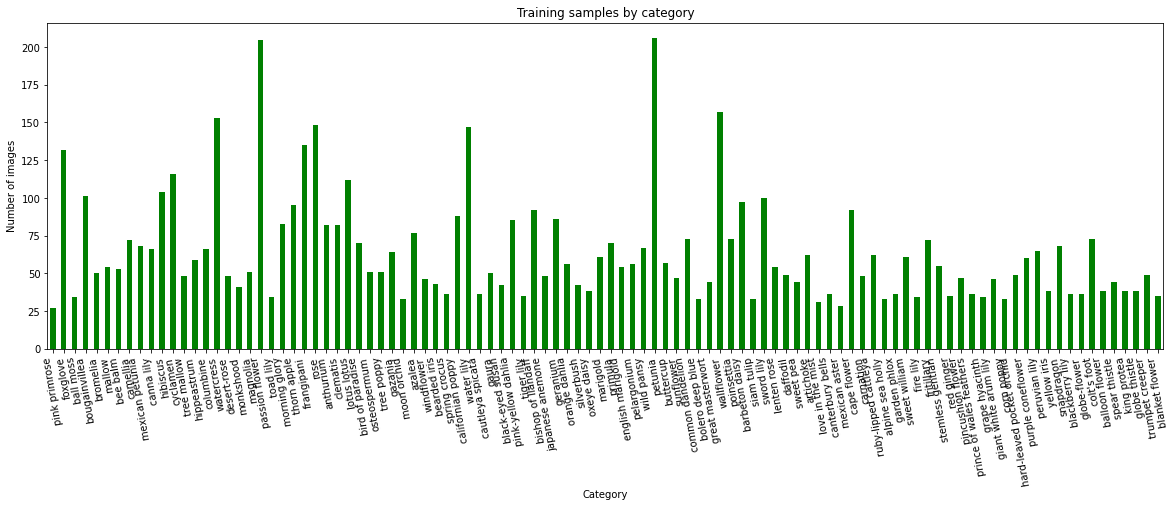

In [13]:
category_names_df.set_index('Category')['Train_num'].plot.bar(color='g', figsize=(20, 6))
plt.xticks(rotation=100)
plt.ylabel('Number of images')
plt.title('Training samples by category')

**VIEWING A RANDOM IMAGE**



Random training sample shape and image: (600, 501, 3) 



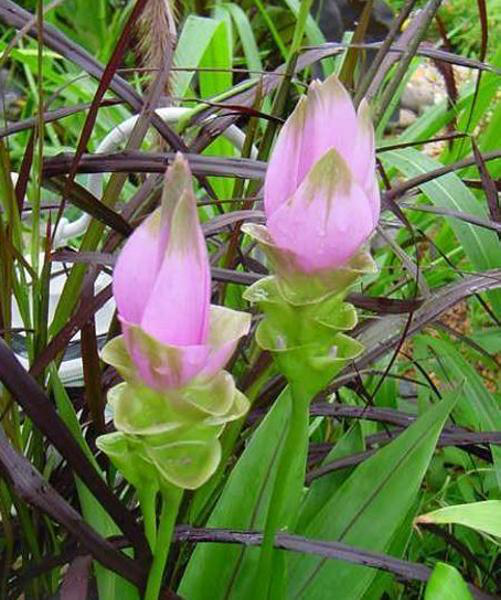

In [14]:
random_class = random.choice(os.listdir(train_dir))
random_image = random.choice(os.listdir(train_dir + '/' + random_class)) 
img = Image.open(train_dir + random_class + '/' + random_image)
print('Random training sample shape and image:', np.array(img).shape, '\n')
img

**BUILDING THE CNN MODEL**

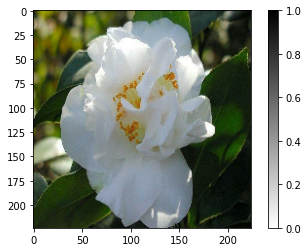

In [15]:
def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image /= 255
    return image, label

training_batches = training_set.cache().shuffle(num_training_examples//4).map(format_image).batch(32).prefetch(1)
testing_batches = test_set.cache().map(format_image).batch(32).prefetch(1)
validation_batches = validation_set.map(format_image).batch(32).prefetch(1)

for image, label in training_batches.take(1):
  plt.figure()
  plt.imshow(image[0].numpy().squeeze(), cmap=plt.cm.binary)
  plt.colorbar()
  plt.grid(False)
  plt.show()

In [16]:
feature_extractor = hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', input_shape=(224,224,3))
feature_extractor.trainable = False

cnn = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

cnn.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])


In [17]:
epochs_count = 30
hist = cnn.fit(x = training_batches, validation_data = validation_batches, epochs = epochs_count)

Epoch 1/30
32/32 [==============================] - 78s 2s/step - loss: 4.6660 - accuracy: 0.0584 - val_loss: 3.0137 - val_accuracy: 0.3804
Epoch 2/30
32/32 [==============================] - 71s 2s/step - loss: 2.2436 - accuracy: 0.6657 - val_loss: 1.9338 - val_accuracy: 0.6618
Epoch 3/30
32/32 [==============================] - 71s 2s/step - loss: 1.1422 - accuracy: 0.9041 - val_loss: 1.4872 - val_accuracy: 0.7412
Epoch 4/30
32/32 [==============================] - 71s 2s/step - loss: 0.6965 - accuracy: 0.9647 - val_loss: 1.2552 - val_accuracy: 0.7686
Epoch 5/30
32/32 [==============================] - 71s 2s/step - loss: 0.4475 - accuracy: 0.9824 - val_loss: 1.1225 - val_accuracy: 0.7775
Epoch 6/30
32/32 [==============================] - 71s 2s/step - loss: 0.3230 - accuracy: 0.9895 - val_loss: 1.0384 - val_accuracy: 0.7912
Epoch 7/30
32/32 [==============================] - 71s 2s/step - loss: 0.2465 - accuracy: 0.9944 - val_loss: 0.9796 - val_accuracy: 0.8049
Epoch 8/30
32/32 [==

**VISUALIZING THE ACCURACY**

In [18]:
training_accuracy = hist.history['accuracy']
validation_accuracy = hist.history['val_accuracy']

training_loss = hist.history['loss']
validation_loss = hist.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

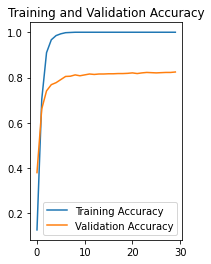

In [19]:
epochs_range = range(epochs_count)
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

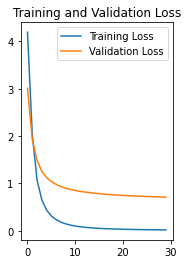

In [20]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**TESTING THE MODEL**

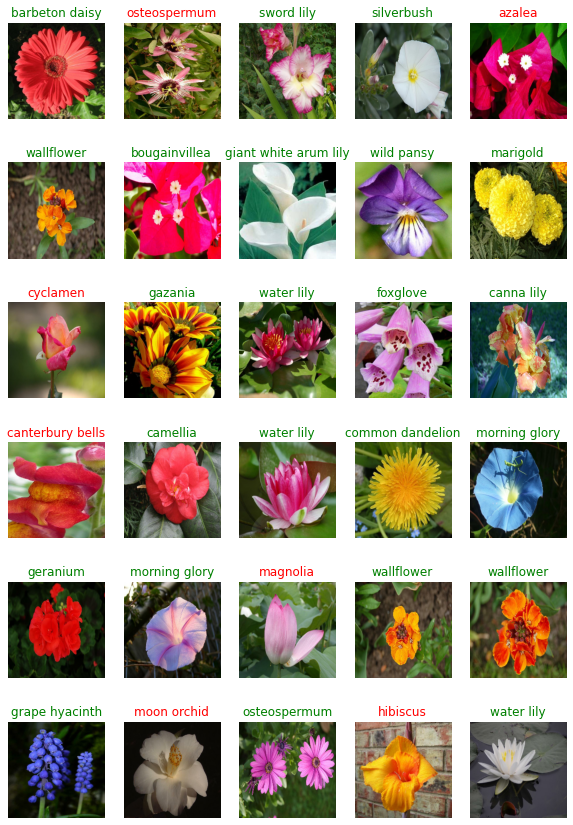

In [23]:
for image_batch, label_batch in testing_batches.take(1):
    ps = cnn.predict(image_batch)
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

plt.figure(figsize=(10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n], cmap = plt.cm.binary)
    color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
    plt.title(class_name[str(np.argmax(ps[n])+1)], color=color)
    plt.axis('off')

In [24]:
results = cnn.evaluate(testing_batches)
print('test loss: {}, test acc: {}'.format(results[0], results[1]))

193/193 [==============================] - 234s 1s/step - loss: 0.8534 - accuracy: 0.7889
test loss: 0.8533530235290527, test acc: 0.7889087796211243


**SAVING THE MODEL AND VISUALIZING THE RESULTS**

In [26]:
saved_keras_model_filepath = './{}.h5'.format('saved_model_1')
cnn.save(saved_keras_model_filepath)
reloaded_keras_model = tf.keras.models.load_model(saved_keras_model_filepath, custom_objects={'KerasLayer': hub.KerasLayer})

In [32]:
def predict(image_path, model_pred, top_k = 2):
  image_path = image_path
  im = Image.open(image_path)
  test_image = np.asarray(im)
  processed_test_image = process_image(test_image)

  ps = model_pred.predict(np.expand_dims(processed_test_image, axis=0))

  top_values, top_indices = tf.math.top_k(ps, top_k)
  print("These are the top propabilities",top_values.numpy()[0])
  top_classes = [class_name[str(value+1)] for value in top_indices.cpu().numpy()[0]]
  print('Of these top classes', top_classes)
  return top_values.numpy()[0], top_classes

In [28]:
def process_image(img):
    image = np.squeeze(img)
    image = tf.image.resize(image, (224, 224))
    image = image/255.0
    return image.numpy()

These are the top propabilities [0.62464386 0.09536009 0.06559186 0.04889021 0.04404452]
Of these top classes ['cape flower', 'gaura', 'fire lily', 'siam tulip', 'red ginger']


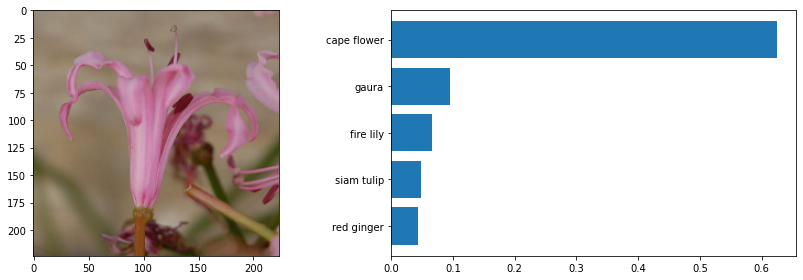

These are the top propabilities [9.8707062e-01 3.8129704e-03 3.7620987e-03 1.7522183e-03 5.0625438e-04]
Of these top classes ['love in the mist', 'stemless gentian', 'balloon flower', 'mexican petunia', 'gaura']


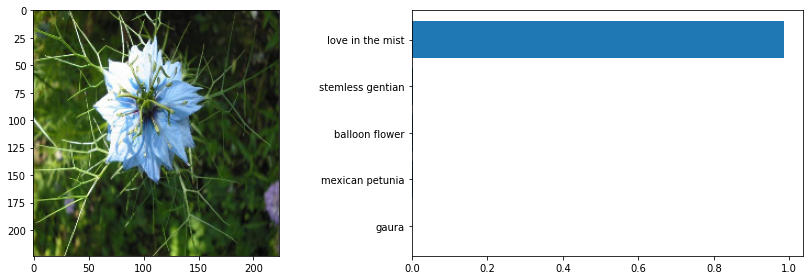

These are the top propabilities [0.83135766 0.04649951 0.02218008 0.00717225 0.00657695]
Of these top classes ['orange dahlia', 'blanket flower', 'gazania', 'english marigold', 'tree poppy']


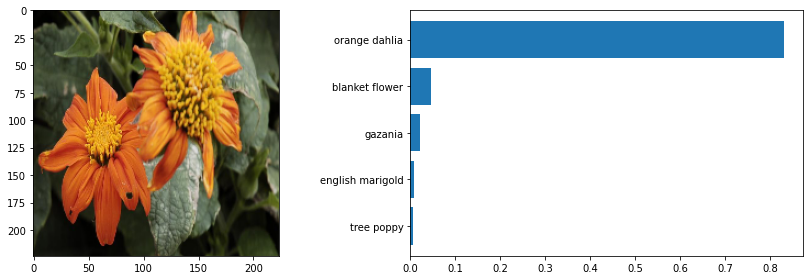

These are the top propabilities [0.62222475 0.2201095  0.04464196 0.03880803 0.01555488]
Of these top classes ['tree mallow', 'hibiscus', 'morning glory', 'sweet william', 'pink primrose']


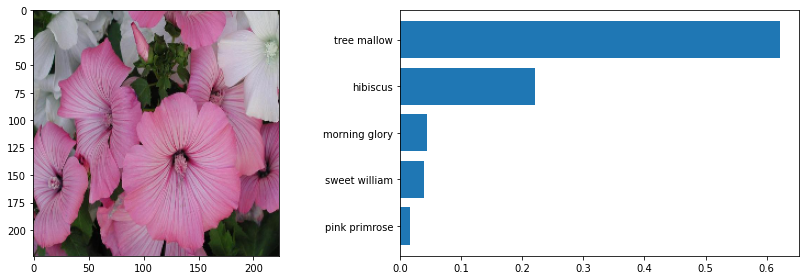

These are the top propabilities [0.9145728  0.02808065 0.01416984 0.0101878  0.00996875]
Of these top classes ['rose', 'trumpet creeper', 'bougainvillea', 'canterbury bells', 'sword lily']


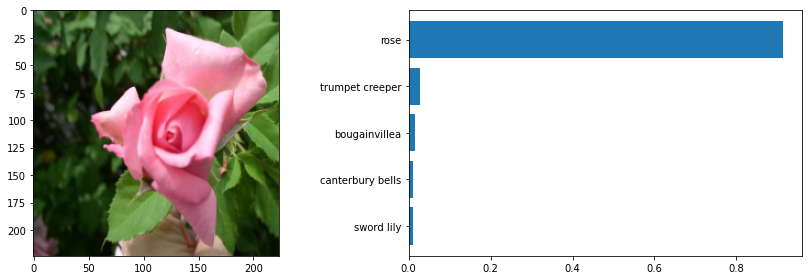

In [33]:
for i in range (5):
  random_class = random.choice(os.listdir(valid_dir))
  random_image = random.choice(os.listdir(valid_dir + '/' + random_class)) 
  im_path = valid_dir + random_class + '/' + random_image
  im = Image.open(im_path)
  test_image = np.asarray(im)
  processed_test_image = process_image(test_image)
  probs, classes = predict(im_path, reloaded_keras_model, 5)
  fig, (ax1, ax2) = plt.subplots(figsize=(12,4), ncols=2)
  ax1.imshow(processed_test_image)
  ax2 = plt.barh(classes[::-1], probs[::-1])
  plt.tight_layout()
  plt.show()